In [4]:
import pandas as pd
import numpy as np
from sklearn.decomposition import FactorAnalysis
from factor_analyzer import FactorAnalyzer, calculate_kmo
import os
import re
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [5]:
# Set up file paths
os.chdir('/Users/nsusser/Desktop/Github/happyDB/')
# Load data 
input_path = 'data/filtered_ratings.csv'
reverse_coded_items_df = pd.read_csv('Profiles/reversed_column_names.csv')
results = pd.read_csv(input_path)


In [6]:
reversed_columns = reverse_coded_items_df['flat_name'].tolist()

max_value = 7

for col in reversed_columns:
    if col in results.columns:
        results[col] = max_value + 1 - results[col]
        print(f"✔ Reversed: {col}")
    else:
        print(f"❌ Not found in results: {col}")

# Save the reversed dataset to csv
results.to_csv('data/reversed_ratings.csv', index=False)

✔ Reversed: CIT_Autonomy_-_Control_other_people_decided_most_of_the_speaker's_life_decisions?
✔ Reversed: CIT_Autonomy_-_Control_the_life_choices_the_speaker_made_were_not_really_theirs?
✔ Reversed: CIT_Autonomy_-_Control_other_people_decided_what_the_speaker_could_and_could_not_do?
✔ Reversed: CIT_Subjective_Well-Being_-_Negative_Feelings_the_speaker_felt_negative_most_of_the_time?
✔ Reversed: CIT_Subjective_Well-Being_-_Negative_Feelings_the_speaker_experienced_unhappy_feelings_most_of_the_time?
✔ Reversed: CIT_Subjective_Well-Being_-_Negative_Feelings_the_speaker_felt_bad_most_of_the_time?
✔ Reversed: PWB_Autonomy_the_speaker_was_not_afraid_to_voice_their_opinions,_even_when_they_were_in_opposition_to_others?
✔ Reversed: PWB_Personal_Growth_the_speaker_was_continuously_in_the_process_of_learning,_changing,_and_growing?
✔ Reversed: PWB_Environmental_Mastery_the_speaker_felt_in_charge_of_the_situation?
✔ Reversed: PWB_Positive_Relations_the_speaker_would_be_described_as_a_giving_perso

In [7]:
items_path = 'dataframes/scales_clean.csv'
items = pd.read_csv(items_path)

# Clean and sanitize column names
items['Scale'] = items['Scale'].str.strip().str.replace(r"\s+", "_", regex=True)
items['Dimension'] = items['Dimension'].str.strip().str.replace(r"\s+", "_", regex=True)
items['Items'] = items['Items'].str.strip().str.replace(r"\s+", "_", regex=True)

# Create flattened column names
cols = [f"{scale}_{dimension}_{item}" for scale, dimension, item in zip(
    items['Scale'], items['Dimension'], items['Items']
)]

In [8]:
#subset df with cols
df_subset = results[cols]
print(df_subset.columns)

Index(['PERMA_Accomplishment_the_speaker_felt_they_were_making_progress_towards_accomplishing_their_goals?',
       'PERMA_Engagement_the_speaker_became_absorbed_in_what_they_were_doing?',
       'PERMA_Positive_Emotion_the_speaker_felt_joyful?',
       'PERMA_Negative_emotion_the_speaker_felt_anxious?',
       'PERMA_Accomplishment_the_speaker_achieved_the_important_goals_they_set_for_themselves?',
       'PERMA_Health_the_speaker_perceived_their_health_positively?',
       'PERMA_Meaning_the_speaker_felt_their_life_was_purposeful_and_meaningful?',
       'PERMA_Relationships_the_speaker_received_help_and_support_from_others_when_needed?',
       'PERMA_Meaning_the_speaker_felt_what_they_did_in_life_was_valuable_and_worthwhile?',
       'PERMA_Engagement_the_speaker_felt_excited_and_interested_in_things?',
       ...
       'CIT_Optimism_the_speaker_expected_more_good_things_in_their_life_than_bad?',
       'CIT_Subjective_Well-Being_-_Life_Satisfaction_the_speaker_felt_in_most_ways_t

In [9]:
#print(df_subset.head())
#standardize df_subset
scaler = StandardScaler()
df_subset = pd.DataFrame(scaler.fit_transform(df_subset), columns=df_subset.columns)

#calculate kmo and bartlett's test
kmo_all, kmo_model = calculate_kmo(df_subset)

#determine optimal number of factors
fa = FactorAnalyzer(rotation=None)
fa.fit(df_subset)
eigenvalues, _ = fa.get_eigenvalues()

#fit factor analysis with optimal factors
optimal_factors = sum(eigenvalues > 1) # or based on scree plot
fa = FactorAnalyzer(n_factors=optimal_factors, rotation='varimax')
fa.fit(df_subset)

#project cols onto factors
factor_scores = fa.transform(df_subset)
for i in range(factor_scores.shape[1]):
    results[f'Factor_{i+1}'] = factor_scores[:, i]




/Users/nsusser/Desktop/Github/happyDB/viz-env/lib/python3.11/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(
/Users/nsusser/Desktop/Github/happyDB/viz-env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nsusser/Desktop/Github/happyDB/viz-env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/nsusser/Desktop/Github/happyDB/viz-env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


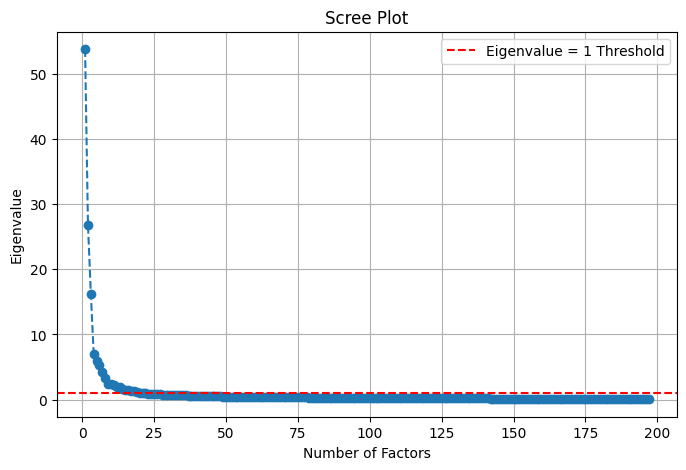

In [10]:
# Plot Scree Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='--')
plt.xlabel('Number of Factors')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot')
plt.axhline(y=1, color='r', linestyle='--', label="Eigenvalue = 1 Threshold")
plt.legend()
plt.grid()
plt.show()

In [11]:

#save csv
results.to_csv('analysis_data/results - factors.csv')

In [12]:
#print top ten
variable_name_mapping = dict(zip(cols, items)) #map cols to variable names
factor_loadings = pd.DataFrame(fa.loadings_, index=items)


for i in range(factor_loadings.shape[1]):
    sorted_loadings = factor_loadings.iloc[:, i].abs().sort_values(ascending=False)
    top_variables = sorted_loadings.head(10).index.tolist()
    print(f'Factor {i+1}: {top_variables}')


# Create an empty list to store the results
factor_loading_results = []

# Iterate through each factor's loadings
for i in range(factor_loadings.shape[1]):
    sorted_loadings = factor_loadings.iloc[:, i].abs().sort_values(ascending=False)
    top_variables = sorted_loadings.head(10).index.tolist()
    top_loadings = sorted_loadings.head(10).values.tolist()
    
    # Append each factor's results to the list
    for var, loading in zip(top_variables, top_loadings):
        factor_loading_results.append({
            'Factor': f'Factor {i+1}',
            'Variable': var,
            'Loading': loading
        })

# Convert the results to a DataFrame
factor_loading_df = pd.DataFrame(factor_loading_results)

# Save to a CSV file
factor_loading_df.to_csv('factor_loadings.csv', index=False)

print("Factor loadings saved to 'factor_loadings.csv'.")


Factor 1: [('PERMA', 'Positive_Emotion', 'the_speaker_felt_joyful?'), ('WBP', 'Positive_Emotions', 'the_speaker_felt_happy?'), ('WBP', 'Optimism', 'the_speaker_felt_very_optimistic_in_the_moment?'), ('WBP', 'Positive_Emotions', 'the_speaker_considered_themselves_happy?'), ('WBP', 'Positive_Emotions', 'the_speaker_felt_cheerful?'), ('WHO-5', 'Well-Being', 'the_speaker_felt_cheerful_and_in_good_spirits?'), ('PERMA', 'Happiness', 'the_speaker_felt_happy_overall?'), ('PANAS', 'Positive', 'the_speaker_was_enthusiastic?'), ('PERMA', 'Positive_Emotion', 'the_speaker_felt_contented?'), ('PERMA', 'Positive_Emotion', 'the_speaker_felt_positive?')]
Factor 2: [('WBP', 'Competence', 'the_speaker_was_competent_and_capable_in_important_activities?'), ('CIT', 'Mastery_-_Self-Efficacy', 'the_speaker_succeeded_when_they_put_their_mind_to_it?'), ('CIT', 'Mastery_-_Self-Efficacy', 'the_speaker_believed_that_they_are_capable_in_most_things?'), ('WBP', 'Meaning', 'the_speaker_felt_a_sense_of_direction?'), (

In [13]:

# Dictionary to store items by factors
factor_items = {}

# Iterate through each factor's loadings
for i in range(factor_loadings.shape[1]):
    sorted_loadings = factor_loadings.iloc[:, i].abs().sort_values(ascending=False)
    top_variables = sorted_loadings.index.tolist()  # Get all variables sorted by absolute loading
    
    # Add variables to the factor_items dictionary
    factor_items[f'Factor {i+1}'] = top_variables

    # Print top 10 variables for the current factor
    top_ten = top_variables[:10]
    print(f'Factor {i+1}: {top_ten}')

# Convert the results to a DataFrame for export (optional)
factor_loading_results = [
    {
        'Factor': factor, 
        'Variables': ', '.join([str(variable) for variable in variables])  # Convert tuples to strings
    }
    for factor, variables in factor_items.items()
]

# Convert to DataFrame and save to CSV
factor_loading_df = pd.DataFrame(factor_loading_results)
factor_loading_df.to_csv('factor_loadings_grouped.csv', index=False)

print("Factor loadings grouped by factor saved to 'factor_loadings_grouped.csv'.")

# Save the factor_items dictionary for visualization (optional)
with open('factor_items.json', 'w') as f:
    import json
    json.dump(factor_items, f)

print("Factor items saved to 'factor_items.json'.")


Factor 1: [('PERMA', 'Positive_Emotion', 'the_speaker_felt_joyful?'), ('WBP', 'Positive_Emotions', 'the_speaker_felt_happy?'), ('WBP', 'Optimism', 'the_speaker_felt_very_optimistic_in_the_moment?'), ('WBP', 'Positive_Emotions', 'the_speaker_considered_themselves_happy?'), ('WBP', 'Positive_Emotions', 'the_speaker_felt_cheerful?'), ('WHO-5', 'Well-Being', 'the_speaker_felt_cheerful_and_in_good_spirits?'), ('PERMA', 'Happiness', 'the_speaker_felt_happy_overall?'), ('PANAS', 'Positive', 'the_speaker_was_enthusiastic?'), ('PERMA', 'Positive_Emotion', 'the_speaker_felt_contented?'), ('PERMA', 'Positive_Emotion', 'the_speaker_felt_positive?')]
Factor 2: [('WBP', 'Competence', 'the_speaker_was_competent_and_capable_in_important_activities?'), ('CIT', 'Mastery_-_Self-Efficacy', 'the_speaker_succeeded_when_they_put_their_mind_to_it?'), ('CIT', 'Mastery_-_Self-Efficacy', 'the_speaker_believed_that_they_are_capable_in_most_things?'), ('WBP', 'Meaning', 'the_speaker_felt_a_sense_of_direction?'), (

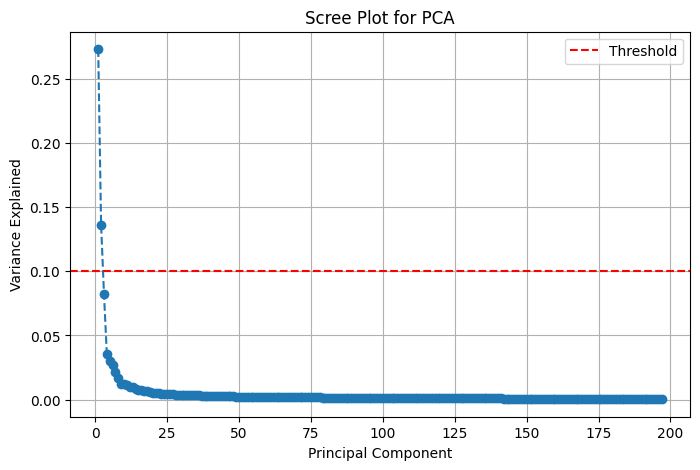

Optimal number of components: 130
        PC1        PC2       PC3       PC4       PC5       PC6       PC7  \
0  6.751848   2.027238  2.495983 -0.883385  1.186183 -0.154432  1.329427   
1  1.624627  -5.255479  0.024384  2.877595 -4.984636 -2.746157  4.158150   
2 -1.556567   0.720282 -5.124594 -4.019368  2.604855 -1.277302 -1.086072   
3  5.228632  12.409686  6.217328 -0.545880  0.527783  0.895594 -0.104613   
4  2.900350  -4.813176  2.081569 -1.891722  1.595124 -0.423591  1.348880   

        PC8       PC9      PC10  ...     PC121     PC122     PC123     PC124  \
0  0.668484 -0.559268  0.293163  ... -0.542191  0.210176  0.306105  0.009283   
1 -1.248740 -0.636629  0.053742  ...  0.416656  0.246368  0.097564  0.263981   
2 -1.274131  0.205719 -1.271343  ...  0.928959  0.147405  0.205035  0.109647   
3  3.669403  1.457090  3.851642  ...  0.032987  0.017120  0.176199 -0.109918   
4 -2.088412  1.520838 -1.260126  ...  0.398605 -0.266612  0.612442 -0.280268   

      PC125     PC126     PC

In [15]:
# Apply PCA
pca = PCA()
principal_components = pca.fit_transform(df_subset)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Scree Plot for PCA
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Scree Plot for PCA')
plt.axhline(y=0.1, color='r', linestyle='--', label="Threshold")
plt.legend()
plt.grid()
plt.show()

# Select number of components (retain 95% variance)
cumulative_variance = np.cumsum(explained_variance)
optimal_components = np.argmax(cumulative_variance >= 0.95) + 1  # Keep 95% variance

print(f"Optimal number of components: {optimal_components}")

# Fit PCA with the optimal number of components
pca_optimal = PCA(n_components=optimal_components)
principal_components_optimal = pca_optimal.fit_transform(df_subset)

# Convert to DataFrame
df_pca = pd.DataFrame(principal_components_optimal, columns=[f'PC{i+1}' for i in range(optimal_components)])

# Display the transformed dataset
print(df_pca.head())  # Print first few rows of the transformed dataset

(197, 21)
Affinity Propagation Clustering Results:
    Factor  Cluster
0        1        0
1        2        0
2        3        1
3        4        0
4        5        1
5        6        0
6        7        2
7        8        2
8        9        3
9       10        3
10      11        3
11      12        1
12      13        2
13      14        1
14      15        4
15      16        0
16      17        4
17      18        3
18      19        3
19      20        4
20      21        2


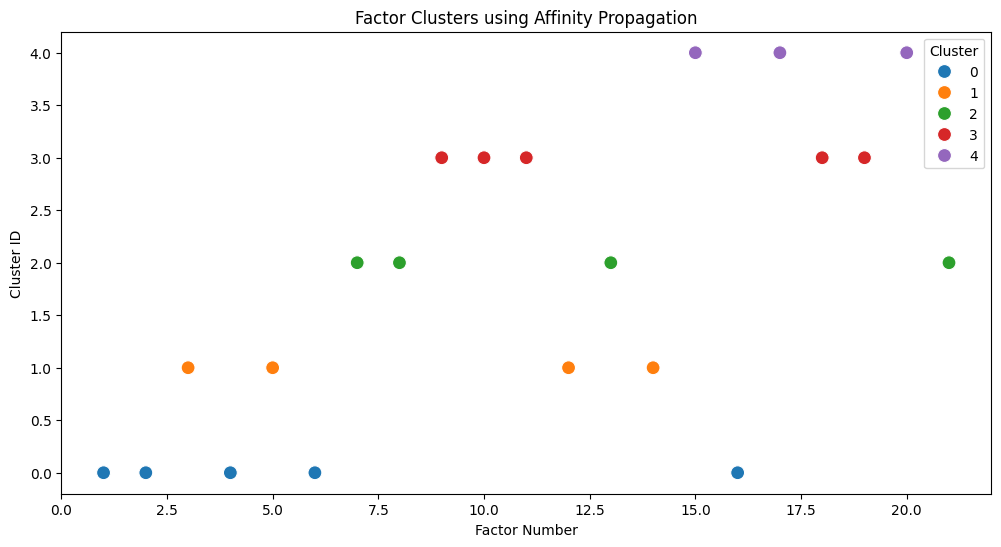

DBSCAN Clustering Results:
    Factor  Cluster
0        1        0
1        2        0
2        3        1
3        4        0
4        5        0
5        6        0
6        7        0
7        8        0
8        9        0
9       10        0
10      11        0
11      12        1
12      13        0
13      14       -1
14      15        0
15      16       -1
16      17        0
17      18       -1
18      19       -1
19      20       -1
20      21       -1


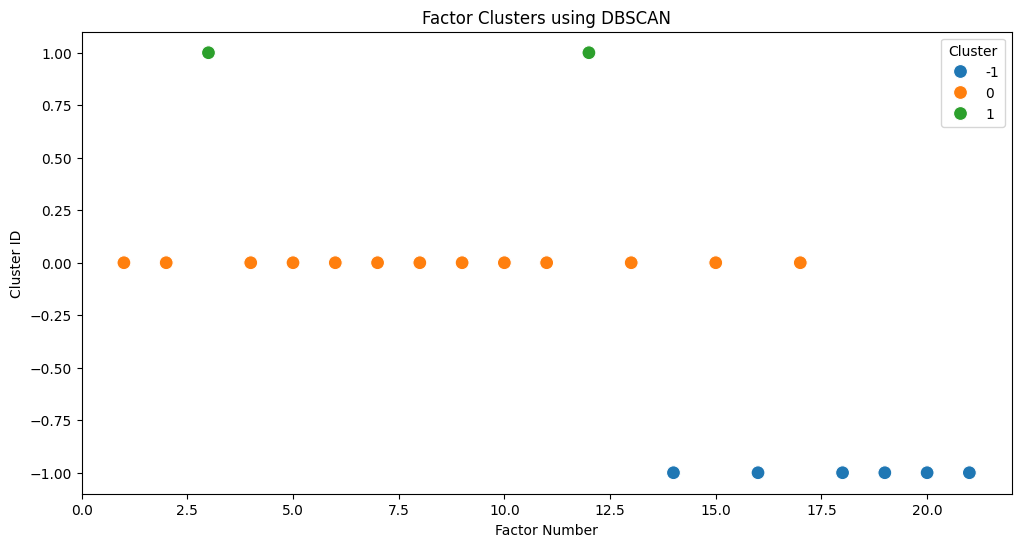

In [16]:
from sklearn.cluster import AffinityPropagation, DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import pdist, squareform
import seaborn as sns

# Load the factor loadings 
factor_loadings_matrix = fa.loadings_  # Use  factor loadings
print(factor_loadings_matrix.shape)
factor_loadings_df = pd.DataFrame(factor_loadings_matrix, index=df_subset.columns)

# Compute similarity matrix (Cosine Similarity)
similarity_matrix = cosine_similarity(factor_loadings_matrix.T)

# Apply Affinity Propagation
aff_prop = AffinityPropagation(affinity="precomputed", damping=0.75)
aff_prop.fit(similarity_matrix)

# Assign clusters
factor_clusters = aff_prop.labels_

# Convert to DataFrame for visualization
factor_cluster_df = pd.DataFrame({"Factor": range(1, len(factor_clusters) + 1), "Cluster": factor_clusters})
print("Affinity Propagation Clustering Results:")
print(factor_cluster_df)

# Visualize Cluster Assignments
plt.figure(figsize=(12, 6))
sns.scatterplot(x=factor_cluster_df["Factor"], y=factor_cluster_df["Cluster"], hue=factor_cluster_df["Cluster"], palette="tab10", s=100)
plt.xlabel("Factor Number")
plt.ylabel("Cluster ID")
plt.title("Factor Clusters using Affinity Propagation")
plt.show()

# Apply DBSCAN for density-based clustering
dbscan = DBSCAN(eps=0.7, min_samples=2, metric="cosine")
dbscan_labels = dbscan.fit_predict(factor_loadings_matrix.T)

# Convert to DataFrame
dbscan_cluster_df = pd.DataFrame({"Factor": range(1, len(dbscan_labels) + 1), "Cluster": dbscan_labels})
print("DBSCAN Clustering Results:")
print(dbscan_cluster_df)

# Plot DBSCAN Clustering
plt.figure(figsize=(12, 6))
sns.scatterplot(x=dbscan_cluster_df["Factor"], y=dbscan_cluster_df["Cluster"], hue=dbscan_cluster_df["Cluster"], palette="tab10", s=100)
plt.xlabel("Factor Number")
plt.ylabel("Cluster ID")
plt.title("Factor Clusters using DBSCAN")
plt.show()


/Users/nsusser/Desktop/Github/happyDB/viz-env/lib/python3.13/site-packages/numpy/_core/_methods.py:194: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


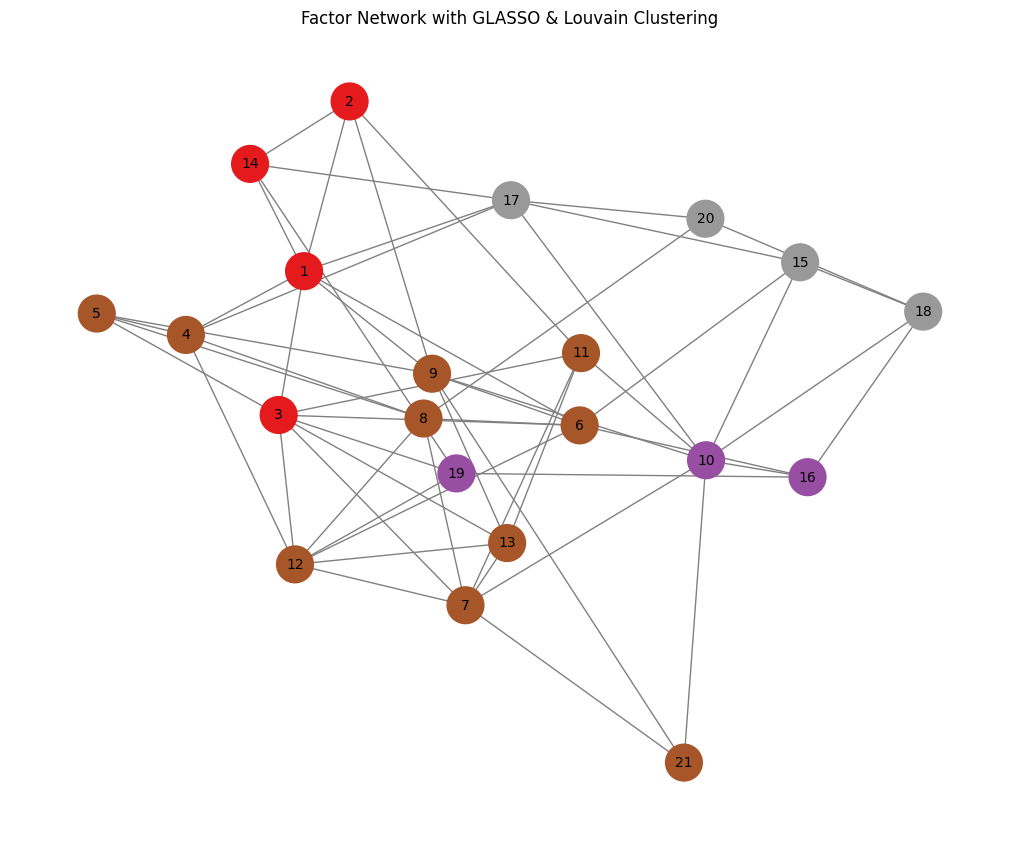

Louvain Clustering Results for Factor Network:
    Factor  Cluster
0        0        0
1        1        0
2        2        0
13      13        0
18      18        1
15      15        1
9        9        1
12      12        2
11      11        2
10      10        2
7        7        2
6        6        2
5        5        2
4        4        2
3        3        2
8        8        2
20      20        2
19      19        3
14      14        3
16      16        3
17      17        3


In [ ]:
import networkx as nx
import seaborn as sns
from sklearn.covariance import GraphicalLassoCV
from community import community_louvain  # Louvain clustering

# Load the factor correlation matrix (from Promax rotation)
factor_correlation_matrix = pd.DataFrame(factor_loadings_matrix).corr()

# Step 1: Apply Graphical Lasso (GLASSO)
glasso = GraphicalLassoCV()
glasso.fit(factor_correlation_matrix)
precision_matrix = glasso.precision_

# Convert precision matrix to adjacency matrix
adj_matrix = np.abs(precision_matrix)  # Take absolute values for network analysis

# Step 2: Create a Network Graph
G = nx.Graph()

# Add nodes (factors)
for i in range(factor_correlation_matrix.shape[0]):
    G.add_node(i, label=f"Factor {i+1}")

# Add edges (connections)
threshold = 0.8  # Tune this based on sparsity
for i in range(adj_matrix.shape[0]):
    for j in range(i+1, adj_matrix.shape[1]):
        if adj_matrix[i, j] > threshold:  # Only keep strong connections
            G.add_edge(i, j, weight=adj_matrix[i, j])

# Step 3: Apply Louvain Clustering to Detect Factor Communities
partition = community_louvain.best_partition(G)

# Assign clusters to nodes
for node, cluster in partition.items():
    G.nodes[node]["community"] = cluster

# Step 4: Visualize the Network
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)  # Force-directed layout
colors = [partition[n] for n in G.nodes]  # Color by cluster

nx.draw(
    G, pos, with_labels=True, labels={i: str(i+1) for i in G.nodes},  # Show only factor numbers
    node_color=colors, cmap=plt.cm.Set1, node_size=700, font_size=10, edge_color="gray"
)
plt.title("Factor Network with GLASSO & Louvain Clustering")
plt.show()

# Step 5: Display Cluster Assignments
factor_network_clusters = pd.DataFrame({"Factor": list(partition.keys()), "Cluster": list(partition.values())})
factor_network_clusters.sort_values(by="Cluster", inplace=True)
print("Louvain Clustering Results for Factor Network:")
print(factor_network_clusters)


Factor Clusters Based on Sentence Representations (197D Data Space):
    Factor  Cluster
0        1        2
1        2        3
2        3        0
3        4        1
4        5        0
5        6        1
6        7        1
7        8        1
8        9        2
9       10        2
10      11        3
11      12        4
12      13        1
13      14        3
14      15        5
15      16        5
16      17        5
17      18        5
18      19        4
19      20        4
20      21        0


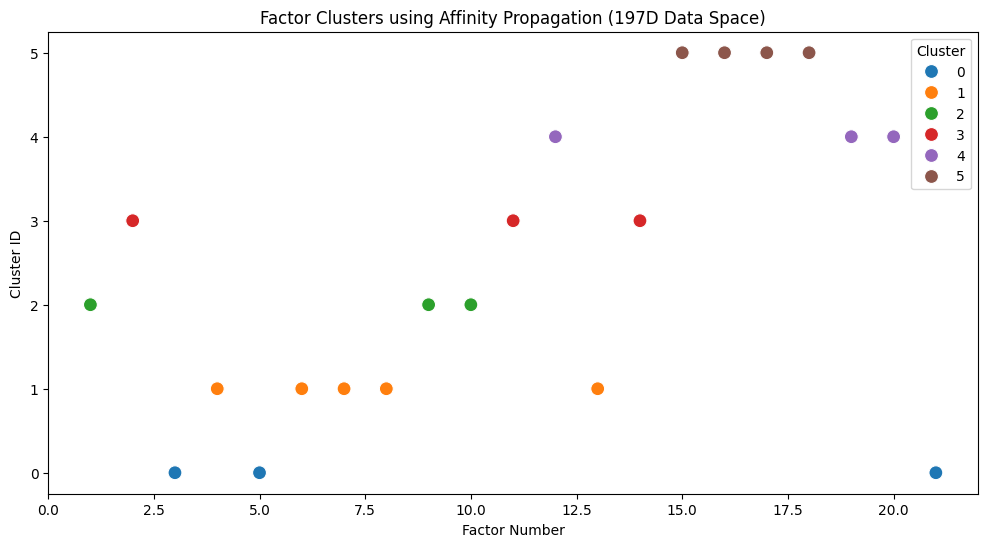

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AffinityPropagation

# Load your data (assuming it's already loaded in 'df')
# df.shape = (100575, 21), where rows are sentences, columns are factors, and values are loadings.
factor_assignments = results.iloc[:, -21:]
#print(factor_assignments.head())
#print(factor_assignments.shape)

# Load sentence vectors (assuming already loaded, shape = (100000, 197))
# sentence_vectors.shape = (100575, 197)
sentence_vectors = df_subset
#print(sentence_vectors.head())
#print(sentence_vectors.shape)\

# Assuming factor_assignments (100000, 21) and sentence_vectors (100000, 197) are already loaded

num_factors = factor_assignments.shape[1]  # Number of factors (21)

# Compute factor representations in 197D space (weighted averaging sentence vectors)
factor_vectors = np.zeros((num_factors, 197))

for i in range(num_factors):
    weights = factor_assignments.iloc[:, i].values.reshape(-1, 1)  # Get weights for factor i
    weighted_vectors = sentence_vectors.values * weights  # Multiply each sentence vector by its loading
    factor_vectors[i] = np.sum(weighted_vectors, axis=0) / np.sum(weights)  # Compute weighted mean

# Compute similarity matrix (Cosine Similarity)
factor_similarity_matrix_197D = cosine_similarity(factor_vectors)

# Apply Affinity Propagation clustering
aff_prop_197D = AffinityPropagation(affinity="precomputed", damping=0.75)
aff_prop_197D.fit(factor_similarity_matrix_197D)

# Assign clusters
factor_clusters_197D = aff_prop_197D.labels_

# Convert to DataFrame for visualization
factor_cluster_df_197D = pd.DataFrame({"Factor": range(1, num_factors + 1), "Cluster": factor_clusters_197D})

# Print results
print("Factor Clusters Based on Sentence Representations (197D Data Space):")
print(factor_cluster_df_197D)

# Visualize Cluster Assignments
plt.figure(figsize=(12, 6))
sns.scatterplot(x=factor_cluster_df_197D["Factor"], y=factor_cluster_df_197D["Cluster"], hue=factor_cluster_df_197D["Cluster"], palette="tab10", s=100)
plt.xlabel("Factor Number")
plt.ylabel("Cluster ID")
plt.title("Factor Clusters using Affinity Propagation (197D Data Space)")
plt.show()

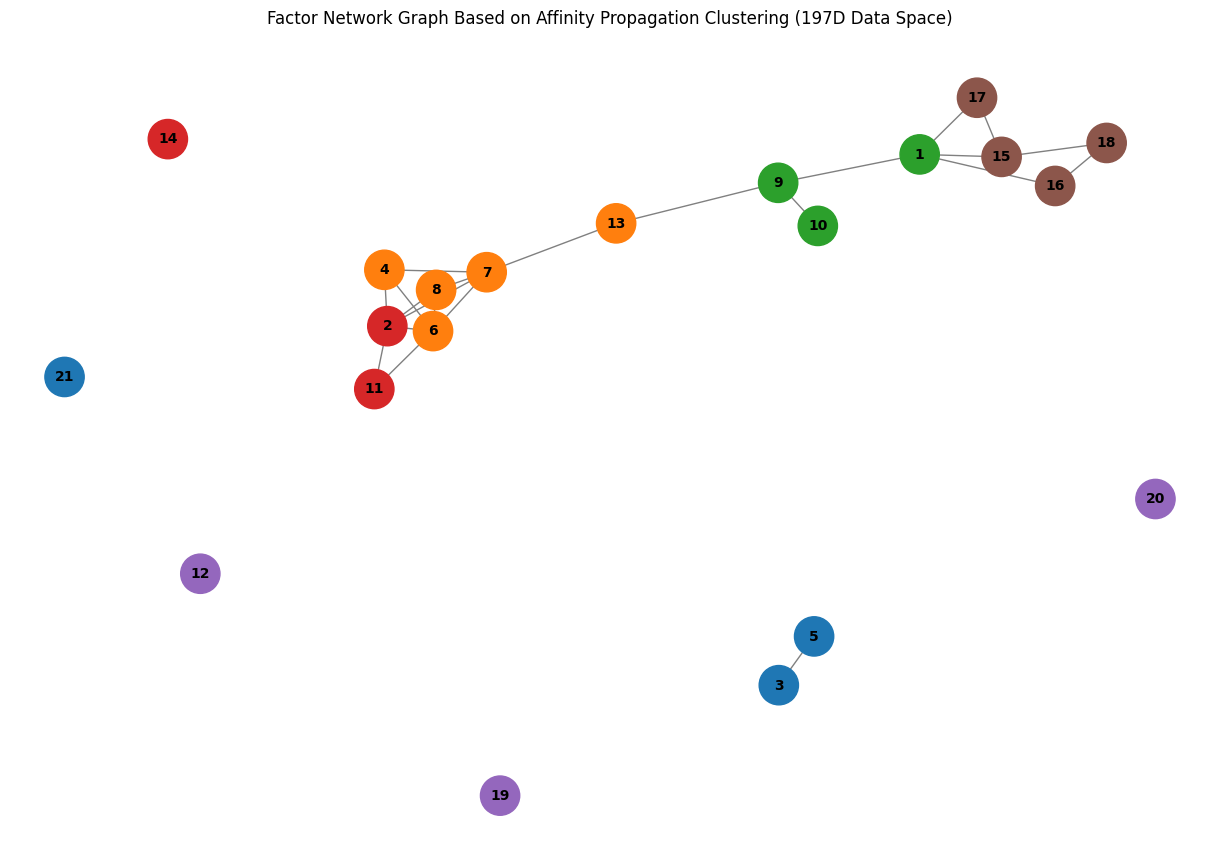

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Create a NetworkX graph
G = nx.Graph()

# Add nodes with cluster attributes9
for factor, cluster in zip(factor_cluster_df_197D["Factor"], factor_cluster_df_197D["Cluster"]):
    G.add_node(factor, cluster=cluster)

# Define a threshold for strong connections (top 15% similarities)
threshold = np.percentile(factor_similarity_matrix_197D, 85)

# Add edges between strongly connected factors
for i in range(num_factors):
    for j in range(i + 1, num_factors):
        if factor_similarity_matrix_197D[i, j] > threshold:
            G.add_edge(i + 1, j + 1, weight=factor_similarity_matrix_197D[i, j])

# Assign colors based on cluster assignment
colors = sns.color_palette("tab10", n_colors=len(set(factor_clusters_197D)))
node_colors = [colors[G.nodes[n]['cluster']] for n in G.nodes]

# Draw the network graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Generate layout for nodes
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=800, edge_color="gray", font_size=10, font_weight="bold")

# Display the graph
plt.title("Factor Network Graph Based on Affinity Propagation Clustering (197D Data Space)")
plt.show()


In [ ]:
'''# try it with zscore
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AffinityPropagation
from scipy.stats import zscore

# Load your data (assuming it's already loaded in 'df')
# df.shape = (100575, 21), where rows are sentences, columns are factors, and values are loadings.
factor_assignments = results.iloc[:, -21:]
#print(factor_assignments.head())
#print(factor_assignments.shape)
factor_assignments = factor_assignments.apply(zscore, nan_policy='omit')  # Standardize factor loadings

# Load sentence vectors (assuming already loaded, shape = (100000, 197))
# sentence_vectors.shape = (100575, 197)
sentence_vectors = df_subset
#print(sentence_vectors.head())
#print(sentence_vectors.shape)\

# Assuming factor_assignments (100000, 21) and sentence_vectors (100000, 197) are already loaded

num_factors = factor_assignments.shape[1]  # Number of factors (21)

# Compute factor representations in 197D space (weighted averaging sentence vectors)
factor_vectors = np.zeros((num_factors, 197))

for i in range(num_factors):
    weights = factor_assignments.iloc[:, i].values.reshape(-1, 1)  # Get weights for factor i
    weighted_vectors = sentence_vectors.values * weights  # Multiply each sentence vector by its loading
    factor_vectors[i] = np.sum(weighted_vectors, axis=0) / np.sum(weights)  # Compute weighted mean

# Compute similarity matrix (Cosine Similarity)
factor_similarity_matrix_197D = cosine_similarity(factor_vectors)

# Apply Affinity Propagation clustering
aff_prop_197D = AffinityPropagation(affinity="precomputed", damping=0.75)
aff_prop_197D.fit(factor_similarity_matrix_197D)

# Assign clusters
factor_clusters_197D = aff_prop_197D.labels_

# Convert to DataFrame for visualization
factor_cluster_df_197D = pd.DataFrame({"Factor": range(1, num_factors + 1), "Cluster": factor_clusters_197D})

# Print results
print("Factor Clusters Based on Sentence Representations (197D Data Space):")
print(factor_cluster_df_197D)

# Visualize Cluster Assignments
plt.figure(figsize=(12, 6))
sns.scatterplot(x=factor_cluster_df_197D["Factor"], y=factor_cluster_df_197D["Cluster"], hue=factor_cluster_df_197D["Cluster"], palette="tab10", s=100)
plt.xlabel("Factor Number")
plt.ylabel("Cluster ID")
plt.title("Factor Clusters using Affinity Propagation (Z-Score 197D Data Space)")
plt.show()
'''

'# try it with zscore\nimport numpy as np\nimport pandas as pd\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nfrom sklearn.metrics.pairwise import cosine_similarity\nfrom sklearn.cluster import AffinityPropagation\nfrom scipy.stats import zscore\n\n# Load your data (assuming it\'s already loaded in \'df\')\n# df.shape = (100575, 21), where rows are sentences, columns are factors, and values are loadings.\nfactor_assignments = results.iloc[:, -21:]\n#print(factor_assignments.head())\n#print(factor_assignments.shape)\nfactor_assignments = factor_assignments.apply(zscore, nan_policy=\'omit\')  # Standardize factor loadings\n\n# Load sentence vectors (assuming already loaded, shape = (100000, 197))\n# sentence_vectors.shape = (100575, 197)\nsentence_vectors = df_subset\n#print(sentence_vectors.head())\n#print(sentence_vectors.shape)\n# Assuming factor_assignments (100000, 21) and sentence_vectors (100000, 197) are already loaded\n\nnum_factors = factor_assignments.shape[1]  # Num

In [ ]:
'''import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Create a NetworkX graph
G = nx.Graph()

# Add nodes with cluster attributes
for factor, cluster in zip(factor_cluster_df_197D["Factor"], factor_cluster_df_197D["Cluster"]):
    G.add_node(factor, cluster=cluster)

# Define a threshold for strong connections (top 15% similarities)
threshold = np.percentile(factor_similarity_matrix_197D, 85)

# Add edges between strongly connected factors
for i in range(num_factors):
    for j in range(i + 1, num_factors):
        if factor_similarity_matrix_197D[i, j] > threshold:
            G.add_edge(i + 1, j + 1, weight=factor_similarity_matrix_197D[i, j])

# Assign colors based on cluster assignment
colors = sns.color_palette("tab10", n_colors=len(set(factor_clusters_197D)))
node_colors = [colors[G.nodes[n]['cluster']] for n in G.nodes]

# Draw the network graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Generate layout for nodes
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=800, edge_color="gray", font_size=10, font_weight="bold")

# Display the graph
plt.title("Factor Network Graph Based on Affinity Propagation Clustering (Z-score 197D Data Space)")
plt.show()'''


'import networkx as nx\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\n# Create a NetworkX graph\nG = nx.Graph()\n\n# Add nodes with cluster attributes\nfor factor, cluster in zip(factor_cluster_df_197D["Factor"], factor_cluster_df_197D["Cluster"]):\n    G.add_node(factor, cluster=cluster)\n\n# Define a threshold for strong connections (top 15% similarities)\nthreshold = np.percentile(factor_similarity_matrix_197D, 85)\n\n# Add edges between strongly connected factors\nfor i in range(num_factors):\n    for j in range(i + 1, num_factors):\n        if factor_similarity_matrix_197D[i, j] > threshold:\n            G.add_edge(i + 1, j + 1, weight=factor_similarity_matrix_197D[i, j])\n\n# Assign colors based on cluster assignment\ncolors = sns.color_palette("tab10", n_colors=len(set(factor_clusters_197D)))\nnode_colors = [colors[G.nodes[n][\'cluster\']] for n in G.nodes]\n\n# Draw the network graph\nplt.figure(figsize=(12, 8))\npos = nx.spring_layout(G, seed=42)  # Generate layout